In [2]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals
from __future__ import absolute_import
from builtins import *  # NOQA
from future import standard_library

standard_library.install_aliases()  # NOQA
import argparse
import os
import logging
import statistics

from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imresize  # preserves single-pixel info _unlike_ img = img[::2,::2]

import pandas as pd
from scipy.misc import imresize

import matplotlib.pyplot as plt

import gym

gym.undo_logger_setup()  # NOQA
from chainer import functions as F
from chainer import links as L
from chainer import optimizers
import numpy as np

import chainerrl
from chainerrl.action_value import DiscreteActionValue
from chainerrl import agents
from chainerrl import experiments
from chainerrl import explorers
from chainerrl import links
from chainerrl import misc
from chainerrl.q_functions import DuelingDQN
from chainerrl import replay_buffer

import atari_wrappers

/Users/sykwer/work/i18-sykwer/visualize_atari/venv/lib/python3.7/site-packages/gym/__init__.py:15: UserWarning: gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration
  warnings.warn("gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration")
/Users/sykwer/work/i18-sykwer/visualize_atari/venv/lib/python3.7/site-packages/chainer/_environment_check.py:38: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Also note that Chainer does not officially support Mac OS X.
Please use it at your own risk.

  ''')  # NOQA


In [3]:
random_seed = 1
outdir = "results"
env_name = "BreakoutNoFrameskip-v4"
load_dir = "results/211288/20180804T155228.325999/10000000_finish"

In [4]:
def make_env():
    env = atari_wrappers.wrap_deepmind(
        atari_wrappers.make_atari(env_name),
        episode_life=False, clip_rewards=False
    )
    env.seed(random_seed)
    env = gym.wrappers.Monitor(env, outdir, mode="evaluation")
    misc.env_modifiers.make_rendered(env)
    return env
env = make_env()

In [5]:
print("observation space shape: {}".format(env.observation_space.shape))
print("action size: {}".format(env.action_space.n))

observation space shape: (4, 84, 84)
action size: 4


In [6]:
q_func = links.Sequence(
    links.NatureDQNHead(activation=F.relu),
    L.Linear(512, env.action_space.n),
    DiscreteActionValue,
)
opt = optimizers.RMSpropGraves(lr=2.5e-4, alpha=0.95, momentum=0.0, eps=1e-2)
opt.setup(q_func)
rep_buf = replay_buffer.ReplayBuffer(10 ** 6)
explorer = explorers.LinearDecayEpsilonGreedy(
    1,0, 0.1, 10 ** 6, lambda: np.random.randint(env.action_space.n),
)

In [7]:
agent = agents.DQN(q_func, opt, rep_buf, gpu=-1, gamma=0.99, explorer=explorer, replay_start_size=5 * 10**4,
           target_update_interval=10**4, clip_delta=True, update_interval=4, batch_accumulator="sum",
            phi=lambda x: np.asarray(x, np.float32) / 255)
agent.load(load_dir)

In [8]:
obs = env.reset()
done = False
test_r = 0
t = 0

obs_list = []
obs_list.append(obs)

while not (done or t == 5 * 60 * 60 // 4): # max_episode_len
    a = agent.act(obs)
    obs, r, done, info = env.step(a)
    obs_list.append(obs)
    test_r += r
    t += 1

agent.stop_episode()
print("episode reward: {}".format(test_r))

WARN: <class 'atari_wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
episode reward: 379.0


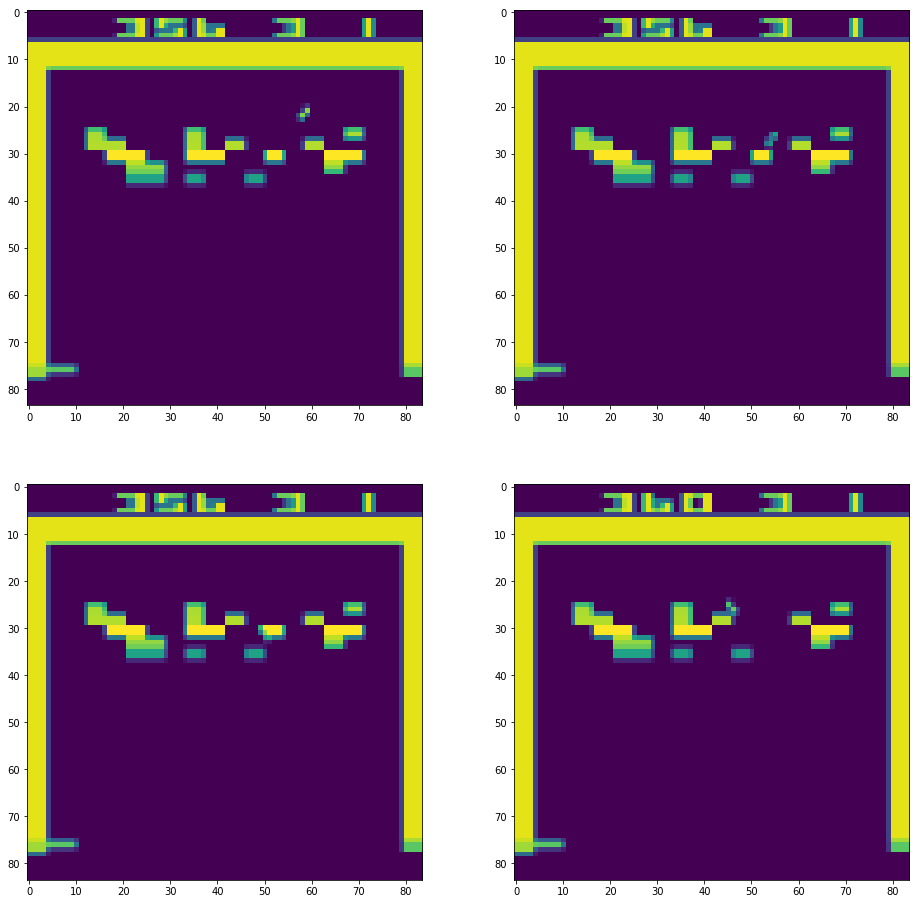

In [156]:
fs = obs_list[1700]
fig = plt.figure(figsize=[16, 16])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(np.asarray(fs)[0])
ax2.imshow(np.asarray(fs)[1])
ax3.imshow(np.asarray(fs)[2])
ax4.imshow(np.asarray(fs)[3])
plt.show()

In [157]:
def get_mask(center, size, radius):
    y, x = np.ogrid[-center[0]:size[0] - center[0], -center[1]:size[1] - center[1]]
    keep = (x*x + y*y) / (x*x + y*y).max() >= 0.01
    msk = np.zeros(size)
    msk[keep] = 1  # select a circle of pixels
    msk = gaussian_filter(msk, sigma=radius)  # blur circle of pixels
    return msk

def occlude(img, msk):
    return img * msk + gaussian_filter(img, sigma=3) * (1 - msk)

In [158]:
def score_frame(agent, input_array, radius=5, density=5, size=(4, 84, 84)):
    channel_num = size[0]
    height = size[1]
    width = size[2]
    
    scores = np.zeros((int(height / density) + 1, int(width / density) + 1))
    qvalues = agent.model(agent.batch_states([input_array], agent.xp, agent.phi)).q_values.data
    
    for i in range(0, 80, density):
        for j in range(0, 80, density):
            mask = get_mask([i, j], size=[height, width], radius=radius)
            perturbed_img = occlude(input_array, mask)
            perturbated_qvalues = agent.model(agent.batch_states([perturbed_img], agent.xp, agent.phi)).q_values.data
            scores[int(i / density), int(j / density)] = np.power(qvalues - perturbated_qvalues, 2).sum()
    pmax = scores.max()
    scores = imresize(scores, size=[size[1], size[2]], interp="bilinear").astype(np.float32)
    return pmax * scores / scores.max()
    
    return scores

In [159]:
mask = get_mask([70, 42], size=[84, 84], radius=1)
perturbated_image = occlude(np.asarray(fs), mask)

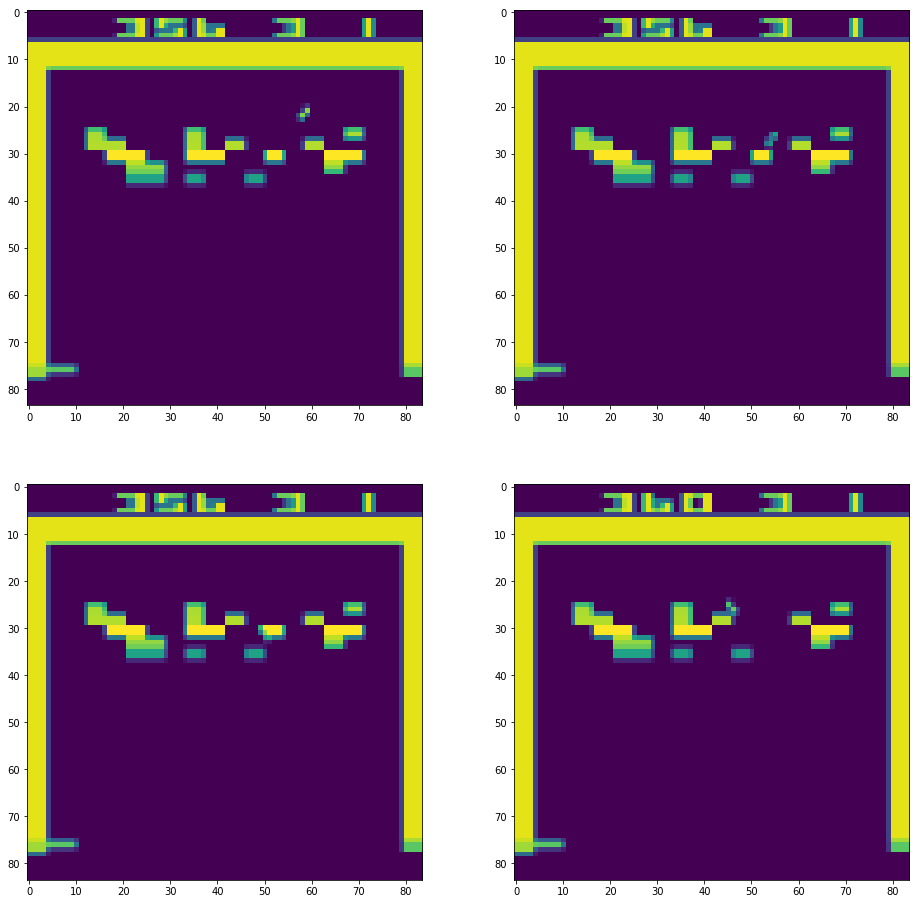

In [160]:
fig = plt.figure(figsize=[16, 16])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(perturbated_image[0])
ax2.imshow(perturbated_image[1])
ax3.imshow(perturbated_image[2])
ax4.imshow(perturbated_image[3])
plt.show()

/Users/sykwer/work/i18-sykwer/visualize_atari/venv/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


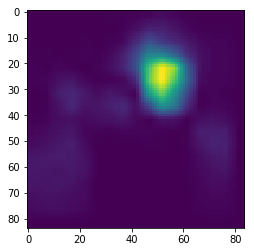

In [161]:
saliency_map = score_frame(agent, np.asarray(fs))
plt.imshow(saliency_map)
plt.show()